# Dataset Preperation

In [1]:
#Need to upload dataset to own Gdrive first
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch.utils.data as data_utils

import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
#Load dataset & reduce size for fast training (Only to familarise myself with pytorch)
dataset = pd.read_csv(r'D:\Desktop\AI_term_8\twitter\TweetsCOV19_3.tsv', sep='\t',header=None, error_bad_lines=False)
dataset = dataset.iloc[:1000]
dataset.columns = ['Tweet Id', 'Username','Timestamp','Followers','Friends','Retweets','Favourites','Entities','Sentiment','Mentions','Hashtags','URLS']
followers = dataset.loc[:,['Followers']]
retweets = dataset.loc[:,['Retweets']]
positive_sentiment = dataset.loc[:,['Sentiment']]

dataset.head()

b'Skipping line 9885107: expected 12 fields, saw 13\n'


,Tweet Id,Username,Timestamp,Followers,Friends,Retweets,Favourites,Entities,Sentiment,Mentions,Hashtags,URLS
0,1267214367881388035,4a493d9ef839054bbf2997fe10219ccd,Sun May 31 22:00:23 +0000 2020,525,285,0,0,orange chicken:Orange_chicken:-1.7264594681340...,1 -1,null;,QuarantineCuisine,null;
1,1267214480192212993,601633f254c336271110c5837e831196,Sun May 31 22:00:50 +0000 2020,4851,4948,56,103,blacklivesmatter:Black_Lives_Matter:-2.0000780...,1 -1,null;,blacklivesmatter,null;
2,1267215059912179712,3b81eab3fb645a50b3d652a837c54ed5,Sun May 31 22:03:08 +0000 2020,145,234,0,0,birds of a feather:Birds_of_a_Feather:-1.45788...,1 -3,QuarantineTrac1 BeardsleeSherri,democrats madness DemocraticPartyPoliticians p...,null;
3,1267215114438168582,d80da4bb147e3829b48e305795e84b0e,Sun May 31 22:03:21 +0000 2020,130,581,0,0,vote leave:Vote_Leave:-1.2547500378858394;tory...,1 -1,lewis_goodall jo_penberthy ShippersUnbound,null;,null;
4,1267216070739464192,9e83fa483d2860d8147f9765d125e40b,Sun May 31 22:07:09 +0000 2020,263,241,0,0,you re telling me:You%27re_Telling_Me%21:-1.79...,2 -3,null;,null;,null;


In [7]:
import itertools 
import re
from collections import Counter
import operator
from itertools import chain
import sys

def get_time(row):
    hour_timestamp = row.Timestamp[11:13]
    return hour_timestamp

def get_weekend(row):
    weekend_stamp = row.Timestamp[0:3]
    if (weekend_stamp == "Sun" or weekend_stamp == "Sat"):
        return 1
    else: 
        return 0

def get_day_of_week(row):
    day_stamp = row.Timestamp[0:3]
    if day_stamp == "Mon":
        return 1
    elif day_stamp == "Tue":
        return 2
    if day_stamp == "Wed":
        return 3
    if day_stamp == "Thu":
        return 4
    if day_stamp == "Fri":
        return 5
    if day_stamp == "Sat":
        return 6
    if day_stamp == "Sun":
        return 7

def get_friends_followers_ratio(row):
    friends = row.Friends
    followers = row.Followers
    if followers == 0:
        return 0
    else:
        return friends/followers

def has_entity(row):
    if row.Entities != "null":
        return 1
    else:
        return 0

        
def no_tweets_per_user(row):
    if row.Entities != "null":
        return 1
    else:
        return 0

def create_no_tweets_per_user_dict(df):
    new_dict = dict()
    for index, row in df.iterrows():
        if row["Username"] not in new_dict.keys():
            new_dict[row["Username"]] = 1
        else:
            new_dict[row["Username"]] += 1
    return new_dict

def assign_number_of_tweets_to_user(row, dict):
    return dict[row.Username]

def create_urls_dict(df):
    new_dict = dict()
    for index, row in df.iterrows():
        if row["URLS"] not in new_dict.keys():
            if row["URLS"] != "null;":
                new_dict[row["URLS"]] = 1
        else:
            new_dict[row["URLS"]] += 1
    return new_dict

def get_url_domain_popularity(row, dict):
    if row.URLS == "null;":
        return 0
    else:
        return dict[row.URLS]

def get_mentions_count(row):
    try:
        return (len([y for y in row if len(y)>0 and y!="null"]))
    except:
        print ("Exception")
        print (row)

def entities_splitter(x):
    entity_list = []
    that_entity_list = x.split(";")
    for counter in range(0, len(that_entity_list)-1):
        each_entity_list = that_entity_list[counter].split(":")
        that_entity = each_entity_list[0]
        if that_entity == "null":
            pass
        else:
            entity_list.append(that_entity)
    return(entity_list)

def get_top_hashtags(df):
    colnames = ['Tweet Id','Hashtags']
    df2 = df[colnames]

    df3 = df2
    df3['Hashtags'] = df2['Hashtags'].str.lower()
    df3['Hashtags'] = df3['Hashtags'].astype(str)

    hashtag_list = df3['Hashtags'].tolist()
    hashtag = []
    for i in tqdm(range(len(hashtag_list))):
        hashtag_all = ''.join(hashtag_list[i])
        hashtag_all_clean = re.sub(r'[^\w]', ' ', hashtag_all)
        hashtag_null_removed = hashtag_all_clean.replace("null", "")
        hashtag_under_removed = hashtag_null_removed.replace("_", "")
        hashtag_dash_removed = hashtag_under_removed.replace("-", "")
        hashtag_longdash_removed = hashtag_dash_removed.replace("ー", "")
        hashtag.append(hashtag_longdash_removed.split(' '))
        
    hashtag_all = ' '.join(hashtag_list)
    hashtag_all_clean = re.sub(r'[^\w]', ' ', hashtag_all)
    hashtag_null_removed = hashtag_all_clean.replace("null", "")
    hashtag_under_removed = hashtag_null_removed.replace("_", "")
    hashtag_dash_removed = hashtag_under_removed.replace("-", "")
    hashtag_longdash_removed = hashtag_dash_removed.replace("ー", "")
    hashtag_list = hashtag_longdash_removed.split(' ')
    hashtag_counter = Counter(hashtag_list)

    dd = dict(sorted(hashtag_counter.items(), key=operator.itemgetter(1),reverse=True))
    #manual cleaning
    try:
        dd.pop('')
        dd.pop('1')
        dd.pop('2')
        dd.pop('0')
        dd.pop('2020')
        dd.pop('0000')
        dd.pop('s')
        dd.pop('19')
        dd.pop('3')
        dd.pop('29')
        dd.pop('21')
    except:
        print ("Error popping value in get_top_hashtags function")
    
    k = Counter(dd)
    high = k.most_common(20) 
    top20hashtag_list = []
    for i in range(len(high)):
        top20hashtag_list.append(high[i][0])
    

    top20hashtagcol = []
    for i in tqdm(range(len(hashtag))):
        counter = 0
        for j in range(len(hashtag[i])):
            if hashtag[i][j] in top20hashtag_list:
                counter += 1
        top20hashtagcol.append(counter)
        
    df['hashtag_popularity'] = top20hashtagcol
    
    return df

def get_top_entities(df):
    # required to get entities_list column from entities_splitter function 
    df["entities_list"] = df["Entities"].apply(entities_splitter)
    entities_list = df['entities_list'].tolist()
    entities_all = list(chain(*entities_list))
    entities_counter = Counter(entities_all)
    dd = dict(sorted(entities_counter.items(), key=operator.itemgetter(1),reverse=True))
    k = Counter(dd)
    high = k.most_common(20) 

    top20entities_list = []
    for i in range(len(high)):
        top20entities_list.append(high[i][0])


    top20entitiescol = []
    for i in tqdm(range(len(entities_list))):
        counter = 0
        for j in range(len(entities_list[i])):
            if entities_list[i][j] in top20entities_list:
                counter += 1
        top20entitiescol.append(counter)

    df['entities_popularity'] = top20entitiescol
    
    return df

def get_top_mentions(df):
    df['Mentions'] = df['Mentions'].str.lower()
    df['Mentions'] = df['Mentions'].astype(str)
    mentions_list = df['Mentions'].tolist()
    for i in range(len(mentions_list)):
        x = mentions_list[i].replace(" ", ",")
        mentions_list[i]= x.split(",")
        if mentions_list[i] == ['null;']:
            mentions_list[i].clear()
    from itertools import chain
    mentions_all = list(chain(*mentions_list))
    mentions_counter = Counter(mentions_all)
    dd = dict(sorted(mentions_counter.items(), key=operator.itemgetter(1),reverse=True))
    try:
        dd.pop('')
        dd.pop('+0000')
    except:
        print ("Error trying to pop value from get top mentions")

    k = Counter(dd)
    high = k.most_common(20) 

    top20mentions_list = []
    for i in range(len(high)):
        top20mentions_list.append(high[i][0])


    top20mentionscol = []
    for i in tqdm(range(len(mentions_list))):
        counter = 0
        for j in range(len(mentions_list[i])):
            if mentions_list[i][j] in top20mentions_list:
                counter += 1
        top20mentionscol.append(counter)

    df['mentions_popularity'] = top20mentionscol
    return df

def compile_top_20_entities_for_each_day(df):

    def get_unique_date(time_stamp):
        day_and_month = time_stamp[4:9]
        year = time_stamp[26:30]
        unique_date = day_and_month + ";" + year
        return unique_date
        
    #2. No. of Top 20 Entities
    entities_list = {} #Storing the top 20 entities per unique day for every day

    for unique_date in df["Timestamp"].unique(): #Iterating through all the unique dates
        #unique_date = get_unique_date(time_stamp)
       
        temp_df = df[df["Timestamp"] == unique_date] #Slicing the dataframe containing that unique date
        that_date_entities_list = {} #Create a dict to store the unique entities in that day
        
        for index,row in temp_df.iterrows(): #Iterating through all the entries in the dataframe for that unique date
            each_entities_list = row["Entities_List"]
            
            for each_entity in each_entities_list: #Iterating through the different entities in that day
                if each_entity == "null;": #Ignore the null entries in the list
                    pass
                elif each_entity in that_date_entities_list: #Check if the entities is already contained in the list
                    that_date_entities_list[each_entity] += 1
                else: #Create a new entry for an unseen entities
                    that_date_entities_list[each_entity] = 1

        sorted_dict = sorted(that_date_entities_list.items(), key=lambda x: x[1], reverse=True) #Sort the dictionary in descending order for frequency of item occurrence
        top_20_entities_for_that_date = dict(itertools.islice(sorted_dict, 20)) #Take the top 20 entities occurrence
        
        entities_list[unique_date] = top_20_entities_for_that_date

    print (entities_list)

    '''
    for index, row in df.iterrows(): #Iterating through every entry in the dataset to determine how many of the hastags it contains
        that_date_entities_list = entities_list[row["Timestamp"]] #Get the unique date for that particular entry
        entry_entity_list = list(df.iloc[[index]]["Entities_List"])[0] #INDEX OUT OF BOUNDS
        
        for each_entity in entry_entity_list: #Iterating through the different entities in that entry 
            if each_entity in that_date_entities_list.keys(): #Check if the entities is in the top 20 entities that day
                df.at[index, "No. of top 20 Entities"] += 1
    '''
        
    print ("entities list", entities_list)

def format_time_data(dataset):
   # def strip_time(timestamp):
   #     try:
   #         return 

    dataset["Timestamp_list"] = dataset["Timestamp"].apply(lambda x: x.split(" "))
    dataset["Timestamp_list"] = dataset["Timestamp_list"].apply(lambda x: x[:4] + x[5:])
    separator = " "
    dataset["Timestamp"] = dataset["Timestamp_list"].apply(lambda x: separator.join(x))
    dataset = dataset.drop(['Timestamp_list'], axis=1)
    dataset["Timestamp"] = dataset["Timestamp"].apply(lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))
    dataset["Timestamp"] = dataset["Timestamp"].apply(lambda x: datetime.strftime(x, '%Y/%m/%d'))

    return dataset



In [4]:
#Preprocessing

In [10]:
from datetime import datetime

dataset = dataset.dropna()

dataset["Entities"] = dataset["Entities"].astype(str)
dataset["Entities"] = dataset["Entities"].apply(lambda x: x.lower())
dataset["Entities_List"] = dataset["Entities"].apply(entities_splitter)

#Lewin
sentiment = dataset["Sentiment"].str.split(" ", n = 1, expand = True) 

dataset["Positive_Sentiment"] = sentiment.iloc[:,[0]]
dataset["Negative_Sentiment"] = sentiment.iloc[:,[1]]
dataset["Positive_Sentiment"] = dataset.Positive_Sentiment.astype(float)
dataset["Negative_Sentiment"] = dataset.Negative_Sentiment.astype(float)
dataset["Overall Sentiment"] = dataset["Positive_Sentiment"] + dataset["Negative_Sentiment"]

dataset["Entity_count"]=dataset["Entities"].str.split(";").apply(lambda x: len([y for y in x if len(y)>0 and y!="null"]))

dataset["Hashtags_count"]=dataset["Hashtags"].str.split(";").apply(lambda x: len([y for y in x if len(y)>0 and y!="null"]))

dataset["Mentions_count"]=dataset["Mentions"].str.split(";").apply(lambda x: len([y for y in x if len(y)>0 and y!="null"]))

dataset["URLS_count"]=dataset["URLS"].str.split(";").apply(lambda x: len([y for y in x if len(y)>0 and y!="null"]))

#Chia
dataset["time"] = dataset.apply(lambda x:get_time(x), axis=1)
dataset["weekend"] = dataset.apply(lambda x:get_weekend(x), axis=1)
dataset["day_of_week"] = dataset.apply(lambda x:get_day_of_week(x), axis=1)
dataset["friends_followers_ratio"] = dataset.apply(lambda x:get_friends_followers_ratio(x), axis=1)

number_tweets_per_users_dict = create_no_tweets_per_user_dict(dataset) #How many times the user appeared in the dataset
dataset["number_of_tweets_per_user"] = dataset.apply(lambda x:assign_number_of_tweets_to_user(x, number_tweets_per_users_dict), axis=1)

urls_dict = create_urls_dict(dataset) #How many times the url appeared in the dataset
dataset["URL_domain_popularity"] = dataset.apply(lambda x: get_url_domain_popularity(x, urls_dict), axis=1)

#Austin
dataset = get_top_hashtags(dataset)
dataset = get_top_entities(dataset)
dataset = get_top_mentions(dataset)

#James

#Converting datetime
#dataset["No. of top 20 Entities"] = 0
#top_20_entities_dict = compile_top_20_entities_for_each_day(dataset) 

#Clean Up - Removing unncesary columns
dataset = dataset.drop(["Entities_List", "entities_list"], axis = 1)

columns = list(dataset)
print (columns)


dataset.head()



D:\Anaconda\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 999/999 [00:00<00:00, 170794.84it/s]
Error popping value in get_top_hashtags function
100%|██████████| 999/999 [00:00<00:00, 341158.58it/s]
Error trying to pop value from get top mentions
100%|██████████| 999/999 [00:00<00:00, 346204.22it/s]
['Tweet Id', 'Username', 'Timestamp', 'Followers', 'Friends', 'Retweets', 'Favourites

,Tweet Id,Username,Timestamp,Followers,Friends,Retweets,Favourites,Entities,Sentiment,Mentions,...,URLS_count,time,weekend,day_of_week,friends_followers_ratio,number_of_tweets_per_user,URL_domain_popularity,hashtag_popularity,entities_popularity,mentions_popularity
0,1267214367881388035,4a493d9ef839054bbf2997fe10219ccd,Sun May 31 22:00:23 +0000 2020,525,285,0,0,orange chicken:orange_chicken:-1.7264594681340...,1 -1,null;,...,0,22,1,7,0.542857,1,0,0,0,0
1,1267214480192212993,601633f254c336271110c5837e831196,Sun May 31 22:00:50 +0000 2020,4851,4948,56,103,blacklivesmatter:black_lives_matter:-2.0000780...,1 -1,null;,...,0,22,1,7,1.019996,1,0,1,1,0
2,1267215059912179712,3b81eab3fb645a50b3d652a837c54ed5,Sun May 31 22:03:08 +0000 2020,145,234,0,0,birds of a feather:birds_of_a_feather:-1.45788...,1 -3,quarantinetrac1 beardsleesherri,...,0,22,1,7,1.613793,1,0,0,1,1
3,1267215114438168582,d80da4bb147e3829b48e305795e84b0e,Sun May 31 22:03:21 +0000 2020,130,581,0,0,vote leave:vote_leave:-1.2547500378858394;tory...,1 -1,lewis_goodall jo_penberthy shippersunbound,...,0,22,1,7,4.469231,1,0,0,0,0
4,1267216070739464192,9e83fa483d2860d8147f9765d125e40b,Sun May 31 22:07:09 +0000 2020,263,241,0,0,you re telling me:you%27re_telling_me%21:-1.79...,2 -3,null;,...,0,22,1,7,0.916350,1,0,0,0,0


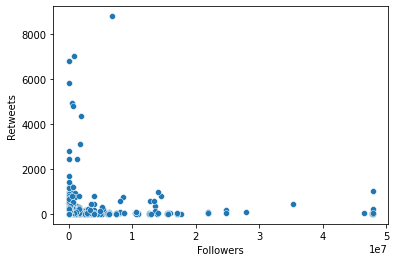

In [ ]:
sns.scatterplot(x="Followers",y='Retweets', data=dataset, palette="muted");

# Linear Regression with Sklearn

In [ ]:
from sklearn.model_selection import train_test_split

#Train test split
x_train, x_test, y_train, y_test = train_test_split(followers, retweets, test_size=0.3, random_state=43)

print(x_train.head(2))

      Followers
4980        119
4154         57


In [ ]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regr.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))


Coefficients: 
 [[9.09415662e-06]]
Mean squared error: 74563.00


# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr_forest = RandomForestRegressor(max_depth=2, random_state=43)
regr_forest.fit(x_train, np.ravel(y_train))

y_pred = regr_forest.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

Mean squared error: 72979.00


# Test Neural Network (Keras)

In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
followers = dataset.loc[:,['Followers','Friends',"Positive Sentiment","Negative Sentiment"]]
retweets = dataset.loc[:,['Retweets']]
followers.head()

#Train test split
x_train, x_test, y_train, y_test = train_test_split(followers, retweets, test_size=0.3, random_state=43)

x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

In [ ]:
def baseline_model():

  model = Sequential()
  model.add(Dense(6, input_dim=4, kernel_initializer='normal',activation='relu'))
  model.add(Dense(3, kernel_initializer='normal',activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.compile(loss='mean_squared_logarithmic_error',optimizer='adam')
  return model


model = baseline_model()
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 4         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

#The mean squared error is negative because scikit-learn inverts so that the metric is maximized instead of minimized. You can ignore the sign of the result.

Baseline: -3.11 (1.13) MSE


In [ ]:
hist = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
110/110 [==============================] - 15s 2ms/step - loss: 2.5128
Epoch 2/10
110/110 [==============================] - 0s 2ms/step - loss: 2.3777
Epoch 3/10
110/110 [==============================] - 0s 2ms/step - loss: 2.3341
Epoch 4/10
110/110 [==============================] - 0s 2ms/step - loss: 2.3174
Epoch 5/10
110/110 [==============================] - 0s 2ms/step - loss: 2.1190
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 2.3026
Epoch 7/10
110/110 [==============================] - 0s 2ms/step - loss: 2.1884
Epoch 8/10
110/110 [==============================] - 0s 2ms/step - loss: 2.1044
Epoch 9/10
110/110 [==============================] - 0s 2ms/step - loss: 2.1430
Epoch 10/10
110/110 [==============================] - 0s 2ms/step - loss: 2.0132


In [ ]:
test_loss = model.evaluate(x=x_test, y=y_test)
print('Test loss:', test_loss)



47/47 [==============================] - 1s 2ms/step - loss: 2.2035
Test loss: 2.2034730911254883


In [ ]:
model(np.array([[267500, 719, 1, 4]]))
#model.save("my_h5_model.h5")
#Issue was model does not reflect large numbers so plan to group similar users together

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[39.300026]], dtype=float32)>

# Personalised models?

In [ ]:
#pd.set_option('display.max_rows', 5000)
#pd.set_option('display.max_columns', 12)
#pd.reset_option('all')
testing = dataset.groupby('Username').nunique()
print(dataset.shape)


(5000, 12)


In [ ]:
print(testing)
testing[testing['Followers']==testing['Followers'].max()]

                                  Tweet Id  Timestamp  ...  Hashtags  URLS
Username                                               ...                
0013aaa4da0461c58d0b1306af75af02         1          1  ...         1     1
001c3d759412a4af2b173b4965b3f35f         1          1  ...         1     1
00356c574c303a0056734a576658f8ac         1          1  ...         1     1
00512b6d56af78834ae96d5bd780c1b1         1          1  ...         1     1
0055252f0fcc4824e2736f95b26a9ee9         1          1  ...         1     1
...                                    ...        ...  ...       ...   ...
ffaa68c5bfb5421de7348c043aa2cefe         1          1  ...         1     1
ffb082db27a247035aa7f5dfc39e6a4e         1          1  ...         1     1
ffdef53692f887e93e47b1b97def2cb3         1          1  ...         1     1
ffe3404cfcbb614633762d2b31d789fc         1          1  ...         1     1
ffed95140bd13f7f37293dd37ecd3c63         1          1  ...         1     1

[4870 rows x 11 columns]

,Tweet Id,Timestamp,Followers,Friends,Retweets,Favourites,Entities,Sentiment,Mentions,Hashtags,URLS
Username,,,,,,,,,,,
2435a45b85628172c5a47122144a7c67,8,8,8,1,7,7,8,5,1,1,8


# BERT (Only using a single feature, have yet to combine BERT embeddings with other features in the Neural Network)

In [ ]:
pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 4.3MB/s 


In [ ]:
pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 358kB 17.7MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 686kB 18.9MB/s 
     |████████████████████████████████| 215kB 24.9MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 645kB 26.0MB/s 
     |████████████████████████████████| 1.2MB 30.9MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 37.2MB 79kB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 2.5MB 4.3MB/s 
     |████████████████████████████████| 3.3MB 33.8MB/s 
     |████████████████████████████████| 901kB 38.7MB/s 


Import Relevant Libraries

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt
from official.nlp import optimization

#Need to upload dataset to own Gdrive first
%cd /content/drive/MyDrive/COVID19/

import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch.utils.data as data_utils


/content/drive/MyDrive/COVID19


Load Dataset

In [ ]:
#Load dataset & reduce size for fast training (Only to familarise myself with pytorch)
dataset = pd.read_csv('TweetsCOV19_052020.tsv', sep='\t',header=None)
dataset = dataset.iloc[:100]
dataset.columns = ['Tweet Id', 'Username','Timestamp','Followers','Friends','Retweets','Favourites','Entities','Sentiment','Mentions','Hashtags','URLS']
retweets = dataset.loc[:,['Retweets']]
#dataset.head()

Create New Column for 'Sentences' (Very preliminary)

In [ ]:
entities = dataset["Entities"].str.split(":",n=1,expand=True)
dataset["BERT_Test"] = entities.iloc[:,[0]]
dataset.head(7)

,Tweet Id,Username,Timestamp,Followers,Friends,Retweets,Favourites,Entities,Sentiment,Mentions,Hashtags,URLS,BERT_Test
0,1255980348229529601,fa5fd446e778da0acba3504aeab23da5,Thu Apr 30 22:00:24 +0000 2020,29697,24040,0,0,null;,1 -1,null;,Opinion Next2blowafrica thoughts,null;,null;
1,1255981220640546816,547501e9cc84b8148ae1b8bde04157a4,Thu Apr 30 22:03:52 +0000 2020,799,1278,4,6,null;,1 -1,null;,null;,null;,null;
2,1255981244560683008,840ac60dab55f6b212dc02dcbe5dfbd6,Thu Apr 30 22:03:58 +0000 2020,586,378,1,2,null;,2 -1,null;,null;,https://www.bbc.com/news/uk-england-beds-bucks...,null;
3,1255981472285986816,37c68a001198b5efd4a21e2b68a0c9bc,Thu Apr 30 22:04:52 +0000 2020,237,168,0,0,null;,1 -1,null;,null;,https://lockdownsceptics.org/2020/04/30/latest...,null;
4,1255981581354905600,8c3620bdfb9d2a1acfdf2412c9b34e06,Thu Apr 30 22:05:18 +0000 2020,423,427,0,0,i hate u:I_Hate_U:-1.8786140035817729;quaranti...,1 -4,null;,null;,null;,i hate u
5,1255982235662024704,491a98bbc105806cb67f46f5e3f3d888,Thu Apr 30 22:07:54 +0000 2020,52,46,0,0,god forbid:God_Forbid:-1.2640735877261988;covi...,2 -4,Danartman BishopStika,null;,https://www.dailymail.co.uk/health/article-826...,god forbid
6,1255982852371554304,916dec763c84916c929bb257ff96187d,Thu Apr 30 22:10:21 +0000 2020,70185,10625,213,926,beijing:Beijing:-1.4222174822860647;covid 19:C...,1 -4,null;,null;,https://canoe.com/news/world/u-s-mulling-poten...,beijing


Clean data

In [ ]:
import re

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text.lower()

#Apply function on BERT_Test column
#Issue with 'NULL'
dataset['BERT_Test']=dataset['BERT_Test'].apply(remove_special_characters)
dataset.head(7)

bert_inputs = dataset.loc[:,['BERT_Test']]


Split Data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bert_inputs, retweets, test_size=0.3, random_state=43)
x_train.head()

,BERT_Test
8,stealth
33,null
45,null
19,wicked
14,leukemia


In [ ]:
import transformers
import numpy as np
from transformers import BertModel, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch


def BERTEmbedding(batch):
    PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
    # Initializing a BERT bert-base-uncased style configuration
    configuration = BertConfig(vocab_size = 500)
    # Initializing a model from the bert-base-uncased style configuration
    model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict =True)
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    
    maxlen = 120 # 42
    outputs = []
    for index, row in batch.items():
        tokenized = tokenizer(row, padding ='max_length', max_length = maxlen, return_tensors = "pt")
        output_last_state = model(**tokenized)
        output_last_state = output_last_state.last_hidden_state
        output = output_last_state.detach().numpy()
        outputs.append(output[0])
    outputs = np.array(outputs)
    print(outputs.shape)
    return outputs
#    tokenized = tokenizer(X_train['utterance'].tolist(), padding ='max_length', max_length = maxlen, return_tensors = "pt")
#    tokenized = tokenizer('hello world', padding ='max_length', max_length = maxlen, return_tensors = "pt")
#   print(tokenized)

    # outputs = model(**tokenized)
    # print(outputs.last_hidden_state)
    # bert_train = X_train["utterance"].apply(lambda x: tokenizer(x, padding ='max_length', max_length = maxlen, add_special_tokens=False)['input_ids'])
    # print(bert_train)

Create BERT Embeddings, I think will take quite long this step

In [ ]:
x_train_v = BERTEmbedding(x_train['BERT_Test'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



(70, 120, 768)


In [ ]:
print(len(x_train_v), 'train sequences')
print(y_train.shape[0], 'test sequences')

70 train sequences
70 test sequences


Creation of Model

In [ ]:
#Create model
input1 = tf.keras.Input((120, 768, ))
text_dense = tf.keras.layers.Dense(3 , activation='relu')(input1)
#text_dense_2 = tf.keras.layers.Dense(2 , activation='relu')(text_dense)
#LSTM Test
text_dense_2 = tf.keras.layers.LSTM(4)(text_dense)
outputs = tf.keras.layers.Dense(1)(text_dense_2)
model = tf.keras.Model(inputs=input1, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 768)]        0         
_________________________________________________________________
dense_8 (Dense)              (None, 120, 3)            2307      
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 2,440
Trainable params: 2,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_logarithmic_error',optimizer='adam',metrics=['mean_squared_logarithmic_error'])

Train...
Epoch 1/5
2/2 [==============================] - 3s 614ms/step - loss: 2.6784 - mean_squared_logarithmic_error: 2.6784 - val_loss: 3.1506 - val_mean_squared_logarithmic_error: 3.1506
Epoch 2/5
2/2 [==============================] - 0s 59ms/step - loss: 2.6056 - mean_squared_logarithmic_error: 2.6056 - val_loss: 3.0947 - val_mean_squared_logarithmic_error: 3.0947
Epoch 3/5
2/2 [==============================] - 0s 53ms/step - loss: 2.5485 - mean_squared_logarithmic_error: 2.5485 - val_loss: 3.0615 - val_mean_squared_logarithmic_error: 3.0615
Epoch 4/5
2/2 [==============================] - 0s 54ms/step - loss: 2.5094 - mean_squared_logarithmic_error: 2.5094 - val_loss: 3.0415 - val_mean_squared_logarithmic_error: 3.0415
Epoch 5/5
2/2 [==============================] - 0s 52ms/step - loss: 2.4863 - mean_squared_logarithmic_error: 2.4863 - val_loss: 3.0242 - val_mean_squared_logarithmic_error: 3.0242


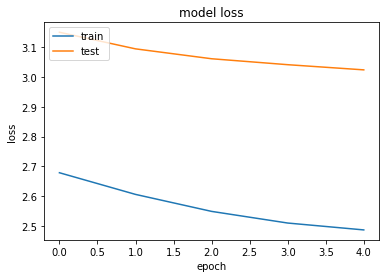

In [ ]:
print('Train...')
hist = model.fit(x_train_v, y_train, 
          epochs=5, 
          validation_split = 0.15)

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
x_test_v = BERTEmbedding(x_test['BERT_Test'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(30, 120, 768)


In [ ]:
model.evaluate(x_test_v,y_test)

1/1 [==============================] - 0s 30ms/step - loss: 2.7808 - mean_squared_logarithmic_error: 2.7808


[2.7808003425598145, 2.7808003425598145]

In [ ]:
d = {'col1': ['Hello covid emergency']}
df2 = pd.DataFrame(data=d)
df2.head()

test_input = BERTEmbedding(df2['col1'])
model.predict(test_input)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1, 120, 768)


array([[0.8596252]], dtype=float32)